# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'data/train.p'
validation_file= 'data/valid.p'
testing_file = 'data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
import numpy as np

In [3]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_valid)

# Number of testing examples.
n_test = len(X_test)

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
# Using all datasets since they are random (though it may be unnecessary)
n_classes = len(np.unique(np.concatenate((y_train, y_valid, y_test), axis=0)))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

9


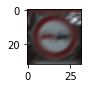

In [5]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
# TODO: Check traffic sign distribution
index = np.random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image, cmap="gray")
print(y_train[index])

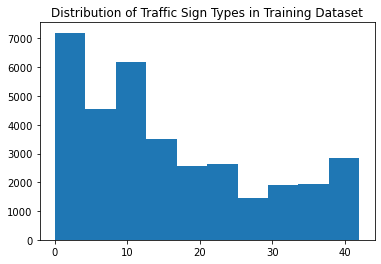

In [6]:
plt.hist(y_train)
plt.title('Distribution of Traffic Sign Types in Training Dataset');

**_Note:_** There is an inequitable distribution of traffic sign types in the training dataset, which may cause the resulting model to perform better in areas where there is more data, than where there isn't. If the model's performance is low, then obtaining more data in relatively low categories may help.

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

#### Normalizing the Images
*Note:* All datasets must be normalized, i.e. training, validation and testing. This is done since if the model is trained on normalized data, then it would expect normalizd data in application. Normalizing the data is done to help the optimizer converge.

In [7]:
import cv2

In [8]:
def normalize_image(image):
    '''
    Normalize the histogram for an RGB image.
    :param image: 3-channel image
    '''
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    normalized = image.copy()

    normalized[:,:,0] = clahe.apply(normalized[:,:,0])
    normalized[:,:,1] = clahe.apply(normalized[:,:,1])
    normalized[:,:,2] = clahe.apply(normalized[:,:,2])

    return normalized

In [9]:
def preprocess_images(images):
    '''
    Applies image histogram equalization, grayscaling and normalization to an array of images.
    :param images: array of 3-channel images
    '''
    # Histogram equalization and grayscaling
    processed = np.array([cv2.cvtColor(normalize_image(img), cv2.COLOR_RGB2GRAY) for img in images])
    # Image normalization
    processed = (processed - np.mean(images))/np.std(images)
    # Expand the array to maintain dimensions since grayscaling removes one dimension
    return np.expand_dims(processed, axis=3)

In [10]:
X_train_modified = X_train.copy()
X_valid_modified = X_valid.copy()
X_test_modified = X_test.copy()

In [11]:
X_train_modified = preprocess_images(X_train_modified)
X_valid_modified = preprocess_images(X_valid_modified)
X_test_modified = preprocess_images(X_test_modified)

#### Shuffling the Data
The training data is shuffled to ensure training is randomized, in the case there is a structural relation in the data. An example is if the data is initially grouped by traffic sign, shuffling will randomize this by interspersing different signs.

In [12]:
from sklearn.utils import shuffle

In [13]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.
# X_train, y_train = shuffle(X_train, y_train)
X_train_modified, y_train = shuffle(X_train_modified, y_train)

### Model Architecture

In [14]:
import tensorflow as tf

## Implement LeNet-5
Implement the [LeNet-5](http://yann.lecun.com/exdb/lenet/) neural network architecture.

This is the only cell you need to edit.
### Input
The LeNet architecture accepts a 32x32xC image as input, where C is the number of color channels. Since MNIST images are grayscale, C is 1 in this case.

### Architecture
**Layer 1: Convolutional.** The output shape should be 28x28x6.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 14x14x6.

**Layer 2: Convolutional.** The output shape should be 10x10x16.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 5x5x16.

**Flatten.** Flatten the output shape of the final pooling layer such that it's 1D instead of 3D. The easiest way to do is by using `tf.contrib.layers.flatten`, which is already imported for you.

**Layer 3: Fully Connected.** This should have 120 outputs.

**Activation.** Your choice of activation function.

**Layer 4: Fully Connected.** This should have 84 outputs.

**Activation.** Your choice of activation function.

**Layer 5: Fully Connected (Logits).** This should have 10 outputs.

### Output
Return the result of the 2nd fully connected layer.

In [15]:
from tensorflow.contrib.layers import flatten
class Model():
    '''
    A class to define a CNN model.
    :param conv_kernel: convolution filter size
    :param pool_kernel: maxpooling kernel size
    :param p_conv: convolution layer remove probability
    :param p_fc: fully-connected layer remove probability
    '''
    def __init__(self, conv_kernel=3, pool_kernel=2, p_conv=0.25, p_fc=0.5, name='Modified LeNet-5 CNN'):
        self.conv_kernel = conv_kernel
        self.pool_kernel = pool_kernel
        self.p_conv = p_conv
        self.p_fc = p_fc
        self.name = name


    def architecture(self, x):
        '''
        A LeNet-5-based CNN.
        '''    
        # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
        mu = 0
        sigma = 0.1
        
        # TODO: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
        wc1 = tf.Variable(tf.truncated_normal([self.conv_kernel,self.conv_kernel,1,32], mu, sigma))
        bc1 = tf.Variable(tf.zeros([32]))
        strides = [1,1,1,1]
        padding = 'VALID'
        
        conv1 = tf.nn.conv2d(x, wc1, strides, padding) + bc1

        # TODO: Activation.
        conv1 = tf.nn.relu(conv1)

        # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
        # k_size (batch_size, height, width, depth) -> depth is 1 since it will create 6/1 output layers    
        k_size = [1,self.pool_kernel,self.pool_kernel,1]
        strides = [1,2,2,1]
        
        conv1 = tf.nn.max_pool(conv1, k_size, strides, padding)

        # TODO: Layer 2: Convolutional. Output = 10x10x16.
        wc2 = tf.Variable(tf.truncated_normal([self.conv_kernel,self.conv_kernel,32,64], mu, sigma))
        bc2 = tf.Variable(tf.zeros([64]))
        strides = [1,1,1,1]
        
        conv2 = tf.nn.conv2d(conv1, wc2, strides, padding) + bc2
        
        # TODO: Activation.
        conv2 = tf.nn.relu(conv2)

        # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
        k_size = [1,self.pool_kernel,self.pool_kernel,1]
        strides = [1,2,2,1]
        
        conv2 = tf.nn.max_pool(conv2, k_size, strides, padding)

        # TODO: Layer 3: Convolutional. Output = 4x4x128.
        wc3 = tf.Variable(tf.truncated_normal([3,3,64,128], mu, sigma))
        bc3 = tf.Variable(tf.zeros([128]))
        strides = [1,1,1,1]
        
        conv3 = tf.nn.conv2d(conv2, wc3, strides, padding) + bc3
        
        # TODO: Activation.
        conv3 = tf.nn.relu(conv3)

        # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
        k_size = [1,self.pool_kernel,self.pool_kernel,1]
        strides = [1,2,2,1]
        
        conv3 = tf.nn.max_pool(conv3, k_size, strides, padding)

        # TODO: Flatten. Input = 5x5x16. Output = 400.
        conv3 = flatten(conv3)

        # Convolution dropout
        conv3 = tf.nn.dropout(conv3, rate=self.p_conv)
        
        # TODO: Layer 3: Fully Connected. Input = 400. Output = 120.
        wfc1 = tf.Variable(tf.truncated_normal([conv3.get_shape().as_list()[1],120], mu, sigma))
        bfc1 = tf.Variable(tf.zeros([120]))
        
        fc1 = tf.add(tf.matmul(conv3, wfc1), bfc1)
        
        # TODO: Activation.
        fc1 = tf.nn.relu(fc1)

        # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
        wfc2 = tf.Variable(tf.truncated_normal([120,84], mu, sigma))
        bfc2 = tf.Variable(tf.zeros([84]))
        
        fc2 = tf.add(tf.matmul(fc1, wfc2), bfc2)
        
        # TODO: Activation.
        fc2 = tf.nn.relu(fc2)

        # Fully Connected Layer Dropout
        fc2 = tf.nn.dropout(fc2, rate=self.p_fc)

        # TODO: Layer 5: Fully Connected. Input = 84. Output = 43.
        wfc3 = tf.Variable(tf.truncated_normal([84,43], mu, sigma))
        bfc3 = tf.Variable(tf.zeros([43]))

        
        logits = tf.add(tf.matmul(fc2, wfc3), bfc3)
        
        return logits    
    
    def init_model(self):
        '''
        Initialize model parameters for training.
        :param x : batch of input images
        :param y : output labels
        '''
        # Defining model execution parameters
        x = tf.placeholder(tf.float32, (None, 32, 32, 1))
        y = tf.placeholder(tf.int32, (None))
        one_hot_y = tf.one_hot(y, 43)

        logits = self.architecture(x)
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
        return x, y, one_hot_y, logits, cross_entropy


In [50]:
class ModelExecutor():
    '''
    A class to execute model initialization, training and validation accuracy logging.
    '''
    def __init__(self, model=Model(), logging=True, save_model=True, epochs=100, batch_size=512, rate=0.001):
        self.model = model
        self.logging = logging
        self.save_model = save_model
        self.epochs = epochs
        self.batch_size = batch_size
        self.rate = rate
        # Model Input Layer
        self.x = None
        # Model Output Layer
        self.y = None
        # Tensorflow Graph Instance
        self.graph = tf.Graph()
        # Moel Execution Parameters
        self.loss_operation = None
        self.training_operation = None
        self.accuracy_operation = None
        # Plotting Parameters
        self.log_batch_step = 1
        self.batches = []
        self.train_loss_batch = []
        self.valid_loss_batch = []
        self.train_acc_batch = []
        self.valid_acc_batch = []


    def init_optimization_params(self):
        '''
        Define optimization parameters for training.
        '''
        # Creating a graph instance with scope corresponding to this class
        with self.graph.as_default() as g:
            with g.name_scope(self.model.name) as scope:
                # Initialize model parameters
                self.x, self.y, one_hot_y, logits, cross_entropy = self.model.init_model()
                self.loss_operation = tf.reduce_mean(cross_entropy)
                optimizer = tf.train.AdamOptimizer(learning_rate = self.rate)
                
                # Training Operation  
                self.training_operation = optimizer.minimize(self.loss_operation)

                # Accuracy Operation
                correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
                self.accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


    def evaluate(self, X_data, y_data):
        '''
        Evaluate the model loss and accuracy by computing the average of the parameters for each batch.
        '''
        num_examples = len(X_data)
        total_loss = 0
        total_accuracy = 0
        sess = tf.get_default_session()
        for offset in range(0, num_examples, self.batch_size):
            batch_x, batch_y = X_data[offset:offset+self.batch_size], y_data[offset:offset+self.batch_size]
            loss, accuracy = sess.run([self.loss_operation,self.accuracy_operation], feed_dict={self.x: batch_x, self.y: batch_y})
            total_loss += (loss * len(batch_x))
            total_accuracy += (accuracy * len(batch_x))
        return (total_loss / num_examples), (total_accuracy / num_examples)

    
    def log(self, batch, training_loss, validation_loss, training_accuracy, validation_accuracy):
        '''
        Model accuracy logging for the training and validation set.
        '''
        if self.logging and not (batch % self.log_batch_step):
            # Log batches
            previous_batch = self.batches[-1] if self.batches else 0
            self.batches.append(self.log_batch_step + previous_batch)
            # Loss
            self.train_loss_batch.append(training_loss)
            self.valid_loss_batch.append(validation_loss)
            # Accuracy
            self.train_acc_batch.append(training_accuracy)
            self.valid_acc_batch.append(validation_accuracy)


    def train(self, X_train, y_train, X_valid, y_valid):
        '''
        Trains a LeNet5-style CNN on the provided training data.
        :param X_train: 32x32 1-channel training image data
        :param y_train: training image labels
        :param X_valid: 32x32 1-channel validation image data
        :param y_valid: validation image labels
        '''

        self.init_optimization_params()

        with tf.Session(graph=self.graph) as sess:
            saver = tf.train.Saver()
            sess.run(tf.global_variables_initializer())
            num_examples = len(X_train)
            
            print("Training...")
            print()
            for i in range(self.epochs):
                X_train, y_train = shuffle(X_train, y_train)
                for offset in range(0, num_examples, self.batch_size):
                    end = offset + self.batch_size
                    batch_x, batch_y = X_train[offset:end], y_train[offset:end]
                    sess.run(self.training_operation, feed_dict={self.x: batch_x, self.y: batch_y})

                # Calculate Training and Validation Accuracies
                training_loss, training_accuracy = self.evaluate(X_train, y_train)    
                validation_loss, validation_accuracy = self.evaluate(X_valid, y_valid)

                # Accuracy Logging
                self.log(i, training_loss, validation_loss, training_accuracy, validation_accuracy)
                
                # Progress Logging
                print("EPOCH {} ...".format(i+1))
                print("Validation Accuracy = {:.3f}".format(validation_accuracy))
                print()
            # Save Model
            if self.save_model:    
                saver.save(sess, './lenet'+self.model.name.replace(" ", "_"))
                print("Model saved")

    def plot_performance(self):
        '''
        Plots the model's performance during training on the training and validation sets.
        '''
        loss_plot = plt.subplot(212)
        loss_plot.set_title('Loss')
        loss_plot.plot(self.batches, self.train_loss_batch, 'g', label='Training Loss')
        loss_plot.plot(self.batches, self.valid_loss_batch, 'x', label='Validation Loss')
        loss_plot.set_xlim([self.batches[0], self.batches[-1]])
        loss_plot.legend(loc=4)
        plt.tight_layout()
        plt.show()

        acc_plot = plt.subplot(212)
        acc_plot.set_title('Accuracy')
        acc_plot.plot(self.batches, self.train_acc_batch, 'r', label='Training Accuracy')
        acc_plot.plot(self.batches, self.valid_acc_batch, 'x', label='Validation Accuracy')
        acc_plot.set_ylim([0, 1.0])
        acc_plot.set_xlim([self.batches[0], self.batches[-1]])
        acc_plot.legend(loc=4)
        plt.tight_layout()
        plt.show()

    def plot_values(self):
        '''
        Returns logged training and validation accuracy scores, and coresponding epoch values.
        '''
        return self.batches, self.train_loss_batch, self.valid_loss_batch, self.train_acc_batch, self.valid_acc_batch


## Train the Model
Run the training data through the training pipeline to train the model.

Before each epoch, shuffle the training set.

After each epoch, measure the loss and accuracy of the validation set.

Save the model after training.

#### Model A
This model uses a 5x5 convolution kernel for the first 2 convolution layers, and a 3x3 for the third convolution layer, with 2x2 maxpool filters, and does not include dropout.

In [51]:
model_5x5 = Model(name='5x5_nodropout', conv_kernel=5, pool_kernel=2, p_conv=0, p_fc=0)
model_a = ModelExecutor(model_5x5, save_model=False)

In [52]:
model_a.train(X_train_modified, y_train, X_valid_modified, y_valid)

Training...

EPOCH 1 ...
Validation Accuracy = 0.730

EPOCH 2 ...
Validation Accuracy = 0.877

EPOCH 3 ...
Validation Accuracy = 0.931

EPOCH 4 ...
Validation Accuracy = 0.935

EPOCH 5 ...
Validation Accuracy = 0.941

EPOCH 6 ...
Validation Accuracy = 0.944

EPOCH 7 ...
Validation Accuracy = 0.945

EPOCH 8 ...
Validation Accuracy = 0.943

EPOCH 9 ...
Validation Accuracy = 0.955

EPOCH 10 ...
Validation Accuracy = 0.952

EPOCH 11 ...
Validation Accuracy = 0.954

EPOCH 12 ...
Validation Accuracy = 0.953

EPOCH 13 ...
Validation Accuracy = 0.954

EPOCH 14 ...
Validation Accuracy = 0.954

EPOCH 15 ...
Validation Accuracy = 0.951

EPOCH 16 ...
Validation Accuracy = 0.957

EPOCH 17 ...
Validation Accuracy = 0.958

EPOCH 18 ...
Validation Accuracy = 0.958

EPOCH 19 ...
Validation Accuracy = 0.957

EPOCH 20 ...
Validation Accuracy = 0.958

EPOCH 21 ...
Validation Accuracy = 0.957

EPOCH 22 ...
Validation Accuracy = 0.958

EPOCH 23 ...
Validation Accuracy = 0.958

EPOCH 24 ...
Validation Accura

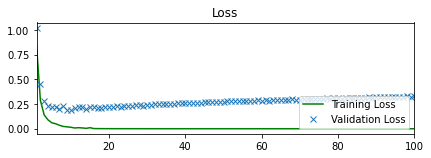

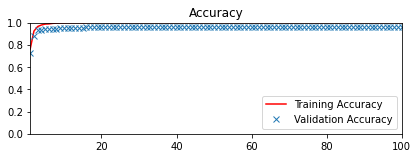

In [53]:
model_a.plot_performance()

#### Model B
This model uses a 5x5 convolution kernel for the first 2 convolution layers, and a 3x3 for the third convolution layer, with 2x2 maxpool filters, and includes dropout for both convolution and fully-connected layers (0.75 keep prob and 0.5 keep prob respectively).

In [54]:
model_5x5_dropout = Model(name='5x5_dropout', conv_kernel=5)
model_b = ModelExecutor(model_5x5_dropout, save_model=False)

In [55]:
model_b.train(X_train_modified, y_train, X_valid_modified, y_valid)

Training...

EPOCH 1 ...
Validation Accuracy = 0.456

EPOCH 2 ...
Validation Accuracy = 0.714

EPOCH 3 ...
Validation Accuracy = 0.810

EPOCH 4 ...
Validation Accuracy = 0.864

EPOCH 5 ...
Validation Accuracy = 0.878

EPOCH 6 ...
Validation Accuracy = 0.907

EPOCH 7 ...
Validation Accuracy = 0.916

EPOCH 8 ...
Validation Accuracy = 0.921

EPOCH 9 ...
Validation Accuracy = 0.923

EPOCH 10 ...
Validation Accuracy = 0.937

EPOCH 11 ...
Validation Accuracy = 0.946

EPOCH 12 ...
Validation Accuracy = 0.944

EPOCH 13 ...
Validation Accuracy = 0.944

EPOCH 14 ...
Validation Accuracy = 0.947

EPOCH 15 ...
Validation Accuracy = 0.950

EPOCH 16 ...
Validation Accuracy = 0.945

EPOCH 17 ...
Validation Accuracy = 0.951

EPOCH 18 ...
Validation Accuracy = 0.956

EPOCH 19 ...
Validation Accuracy = 0.955

EPOCH 20 ...
Validation Accuracy = 0.961

EPOCH 21 ...
Validation Accuracy = 0.961

EPOCH 22 ...
Validation Accuracy = 0.954

EPOCH 23 ...
Validation Accuracy = 0.963

EPOCH 24 ...
Validation Accura

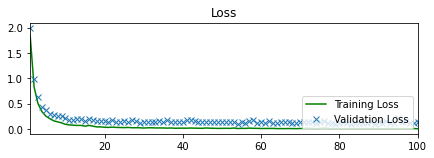

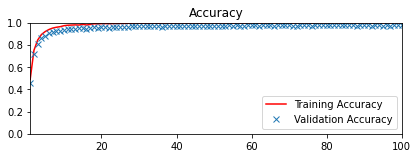

In [56]:
model_b.plot_performance()

#### Model C
This model uses a 3x3 convolution kernel for all convolution layers, with 2x2 maxpool filters, and includes dropout for both convolution and fully-connected layers (0.75 keep prob and 0.5 keep prob respectively)

In [57]:
model_3x3_dropout = Model(name='3x3_dropout')
model_c = ModelExecutor(model_3x3_dropout)

In [58]:
model_c.train(X_train_modified, y_train, X_valid_modified, y_valid)

Training...

EPOCH 1 ...
Validation Accuracy = 0.404

EPOCH 2 ...
Validation Accuracy = 0.712

EPOCH 3 ...
Validation Accuracy = 0.803

EPOCH 4 ...
Validation Accuracy = 0.845

EPOCH 5 ...
Validation Accuracy = 0.882

EPOCH 6 ...
Validation Accuracy = 0.899

EPOCH 7 ...
Validation Accuracy = 0.912

EPOCH 8 ...
Validation Accuracy = 0.919

EPOCH 9 ...
Validation Accuracy = 0.936

EPOCH 10 ...
Validation Accuracy = 0.931

EPOCH 11 ...
Validation Accuracy = 0.936

EPOCH 12 ...
Validation Accuracy = 0.944

EPOCH 13 ...
Validation Accuracy = 0.947

EPOCH 14 ...
Validation Accuracy = 0.948

EPOCH 15 ...
Validation Accuracy = 0.951

EPOCH 16 ...
Validation Accuracy = 0.954

EPOCH 17 ...
Validation Accuracy = 0.945

EPOCH 18 ...
Validation Accuracy = 0.953

EPOCH 19 ...
Validation Accuracy = 0.951

EPOCH 20 ...
Validation Accuracy = 0.960

EPOCH 21 ...
Validation Accuracy = 0.958

EPOCH 22 ...
Validation Accuracy = 0.956

EPOCH 23 ...
Validation Accuracy = 0.963

EPOCH 24 ...
Validation Accura

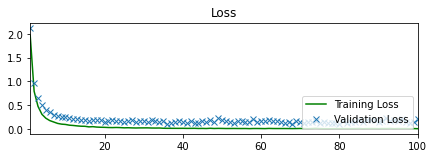

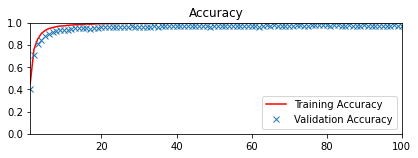

In [59]:
model_c.plot_performance()

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [26]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [27]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Predict the Sign Type for Each Image

In [28]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

### Analyze Performance

In [29]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [30]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [31]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")